<a href="https://colab.research.google.com/github/reshalfahsi/quantum-lenet/blob/master/Image_Recognition_with_Quantum_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Recognition with Quantum LeNet**

## **Important Libraries**

### **Install**

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 167.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 205.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 191.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 222.5 MB/s eta 0:00:00


### **Import**

In [ ]:
import os
import cv2
import copy
import math
import random
import warnings

import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from PIL import Image

from torchvision.datasets import MNIST
from torchvision.transforms import v2 as T

import pennylane as qml
from pennylane import numpy as np

try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics.classification import Accuracy

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [ ]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 17619376


In [ ]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE       = "max"

In [ ]:
MAX_EPOCH = 85
NUM_LAYER = 3
NUM_QUBIT = 4
NUM_CLASSES = 10
BATCH_SIZE = 100
LEARNING_RATE = 4e-3
BASE_LR_SCALE = 3e-4

In [ ]:
QUANTUM_DEVICE = "default.qubit"

## **Dataset**

In [ ]:
DATASET_TRANSFORM = T.Compose(
    [
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,)),
    ]
)

In [ ]:
class MNISTDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "experiment/dataset",
        batch_size: int = BATCH_SIZE,
        transform = DATASET_TRANSFORM,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transform

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        if stage == "test":
            self.test_set = MNIST(
                self.data_dir,
                transform=self.transform,
                train=False,
            )

        if stage == "fit":
            mnist_full = MNIST(
                self.data_dir,
                transform=self.transform,
                train=True,
            )
            self.train_set, self.val_set = data.random_split(
                mnist_full,
                [54000, 6000],
                generator=torch.Generator().manual_seed(SEED),
            )

    def train_dataloader(self):
        return data.DataLoader(
            self.train_set,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return data.DataLoader(self.val_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(self.test_set,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2,
            persistent_workers=True,
        )

In [ ]:
DATASET = MNISTDataModule

## **Model**

### **Utils**

In [ ]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Module**

In [ ]:
dev = qml.device(QUANTUM_DEVICE, wires=NUM_QUBIT)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(NUM_QUBIT))
    qml.BasicEntanglerLayers(weights, wires=range(NUM_QUBIT))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(NUM_QUBIT)]

In [ ]:
class QuantumLeNet(nn.Module):
    def __init__(self):
        super(QuantumLeNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.BatchNorm2d(6),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.BatchNorm2d(16),
        )

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 4 * 4, 3 * NUM_QUBIT)
        self.fc2 = nn.Linear(3 * NUM_QUBIT, 10)

        self.qfc1_1 = qml.qnn.TorchLayer(
            qnode,
            {"weights": (NUM_LAYER, NUM_QUBIT)},
        )
        self.qfc1_2 = qml.qnn.TorchLayer(
            qnode,
            {"weights": (NUM_LAYER, NUM_QUBIT)},
        )
        self.qfc1_3 = qml.qnn.TorchLayer(
            qnode,
            {"weights": (NUM_LAYER, NUM_QUBIT)},
        )

    def forward(self, x):

        N = x.shape[0]

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = x.view(N, 16 * 4 * 4)

        x = F.relu(self.fc1(x))

        x = torch.split(x, 3, dim=1)
        x1 = self.qfc1_1(x[0])
        x2 = self.qfc1_2(x[1])
        x3 = self.qfc1_3(x[2])
        x = F.relu(torch.cat([x1, x2, x3], dim=1))

        x = self.fc2(x)

        return x

### **Wrapper**

In [ ]:
class QLeNet(L.LightningModule):
    def __init__(self, labeling_model=None):
        super().__init__()

        self.lr = LEARNING_RATE
        self.max_epoch = MAX_EPOCH
        self.lr_now = self.lr * 1e3

        self.arch = QuantumLeNet()

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES)

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

    def forward(self, x):
        return self.arch(x)

    def training_step(self, batch, batch_nb):

        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])

        loss = F.cross_entropy(y_hat, y)
        self.train_accuracy.update(y_hat.softmax(1), y)

        acc = self.train_accuracy.compute().data.cpu()

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.data)
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

    def on_train_epoch_end(self):
        self.train_loss.append(
            self.train_loss_recorder.show().data.cpu().numpy(),
        )
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.data)
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(
                self.val_loss_recorder.show().data.cpu().numpy()
            )
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()
        img = cv2.imread(loss_img_file)
        cv2_imshow(img)

        # Accuracy
        acc_img_file = f"experiment/training/{MODEL_NAME}_acc_plot.png"
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.clf()
        img = cv2.imread(acc_img_file)
        cv2_imshow(img)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.arch.parameters(), lr=self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.CyclicLR(
                optimizer,
                base_lr=BASE_LR_SCALE * self.lr,
                max_lr=self.lr,
                cycle_momentum=False,
            ),
            "name": "lr_scheduler",
        }

        return [optimizer], [lr_scheduler]

In [ ]:
MODEL_NAME = QLeNet.__name__
MODEL = QLeNet
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

INFO: Seed set to 17619376
INFO:lightning.fabric.utilities.seed:Seed set to 17619376


QLeNet


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]


Extracting experiment/dataset/MNIST/raw/train-images-idx3-ubyte.gz to experiment/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 467kB/s]


Extracting experiment/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to experiment/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.61MB/s]


Extracting experiment/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to experiment/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.71MB/s]


Extracting experiment/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to experiment/dataset/MNIST/raw



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | arch           | QuantumLeNet       | 5.9 K  | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
3 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
5.9 K     Trainable params
0         Non-trainable params
5.9 K     Total params
0.023     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | arch           | QuantumLeNet       | 5.9 K  | train
1 | train_accuracy | MulticlassAc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0010808760000000001 - Epoch: 0


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002160552 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0032402280000000004 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003680096 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0026004199999999996 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0015207439999999997 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0004410680000000013 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0006410080000000006 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.001720683999999999 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002800360000000001 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0038800360000000025 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003040287999999999 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.001960612000000001 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0008809360000000026 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0002011399999999993 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0012808160000000012 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002360491999999999 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0034401680000000013 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0034801560000000003 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0024004799999999987 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0013208040000000005 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.00024112799999999847 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0008409480000000035 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0019206240000000019 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0030003 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003920024000000002 - Epoch: 25


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0028403480000000034 - Epoch: 26


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0017606720000000052 - Epoch: 27


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0006809959999999998 - Epoch: 28


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0004010799999999986 - Epoch: 29


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.001480755999999997 - Epoch: 30


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0025604320000000022 - Epoch: 31


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003640108000000001 - Epoch: 32


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003280216000000001 - Epoch: 33


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002200540000000003 - Epoch: 34


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0011208639999999975 - Epoch: 35


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 4.118799999999915e-05 - Epoch: 36


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0010408879999999991 - Epoch: 37


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0021205639999999975 - Epoch: 38


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003200240000000003 - Epoch: 39


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003720083999999999 - Epoch: 40


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0026404080000000008 - Epoch: 41


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0015607320000000024 - Epoch: 42


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0004810559999999969 - Epoch: 43


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0006010200000000015 - Epoch: 44


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0016806959999999998 - Epoch: 45


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002760371999999998 - Epoch: 46


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0038400480000000035 - Epoch: 47


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003080275999999998 - Epoch: 48


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0020006 - Epoch: 49


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0009209240000000018 - Epoch: 50


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0001611519999999966 - Epoch: 51


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0012408280000000091 - Epoch: 52


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002320503999999993 - Epoch: 53


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0034001800000000057 - Epoch: 54


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.00352014400000001 - Epoch: 55


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0024404679999999977 - Epoch: 56


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0013607919999999996 - Epoch: 57


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0002811160000000011 - Epoch: 58


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0008009599999999973 - Epoch: 59


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0018806359999999956 - Epoch: 60


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0029603119999999936 - Epoch: 61


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.003960011999999994 - Epoch: 62


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0028803359999999955 - Epoch: 63


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0018006599999999973 - Epoch: 64


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.000720983999999999 - Epoch: 65


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.00036109199999999944 - Epoch: 66


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0014407679999999979 - Epoch: 67


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002520443999999996 - Epoch: 68


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0036001199999999944 - Epoch: 69


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0033202039999999933 - Epoch: 70


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0022405279999999947 - Epoch: 71


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0011608519999999967 - Epoch: 72


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 8.11759999999983e-05 - Epoch: 73


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0010009 - Epoch: 74


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002080575999999998 - Epoch: 75


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0031602519999999966 - Epoch: 76


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0037600720000000054 - Epoch: 77


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0026803960000000068 - Epoch: 78


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0016007199999999945 - Epoch: 79


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0005210439999999961 - Epoch: 80


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0005610320000000023 - Epoch: 81


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.0016407080000000007 - Epoch: 82


Validation: |          | 0/? [00:00<?, ?it/s]

[QLeNet] Learning Rate Changed: 0.002720383999999999 - Epoch: 83


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=85` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=85` reached.


[QLeNet] Learning Rate Changed: 0.003800059999999997 - Epoch: 84


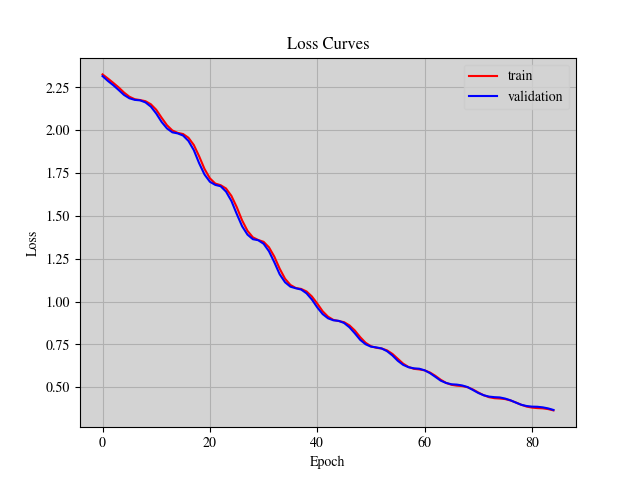

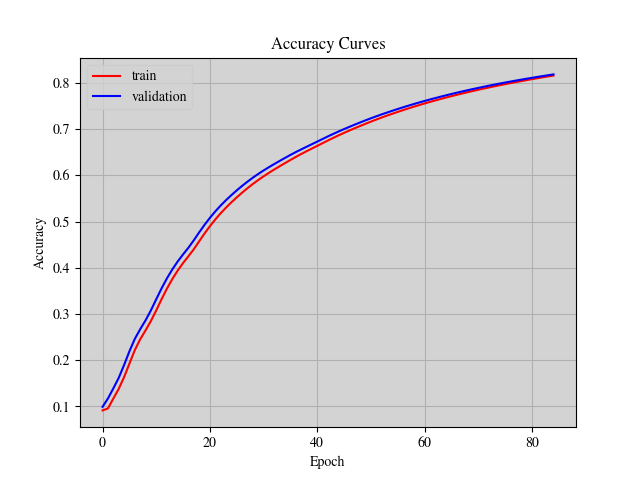

<Figure size 640x480 with 0 Axes>

In [ ]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)

    model = MODEL()
    datamodule = DATASET()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, datamodule=datamodule, ckpt_path=ckpt_path)

_train_loop()

## **Testing**

In [ ]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = MODEL(MODEL().arch)
    datamodule = DATASET()
    trainer.test(model=model, datamodule=datamodule, ckpt_path=BEST_MODEL_PATH)

_test_loop()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Restoring states from the checkpoint path at experiment/model/QLeNet_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/QLeNet_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at experiment/model/QLeNet_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/model/QLeNet_best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9640440344810486     │
│         test_loss         │    0.3637794256210327     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

<Figure size 640x480 with 0 Axes>

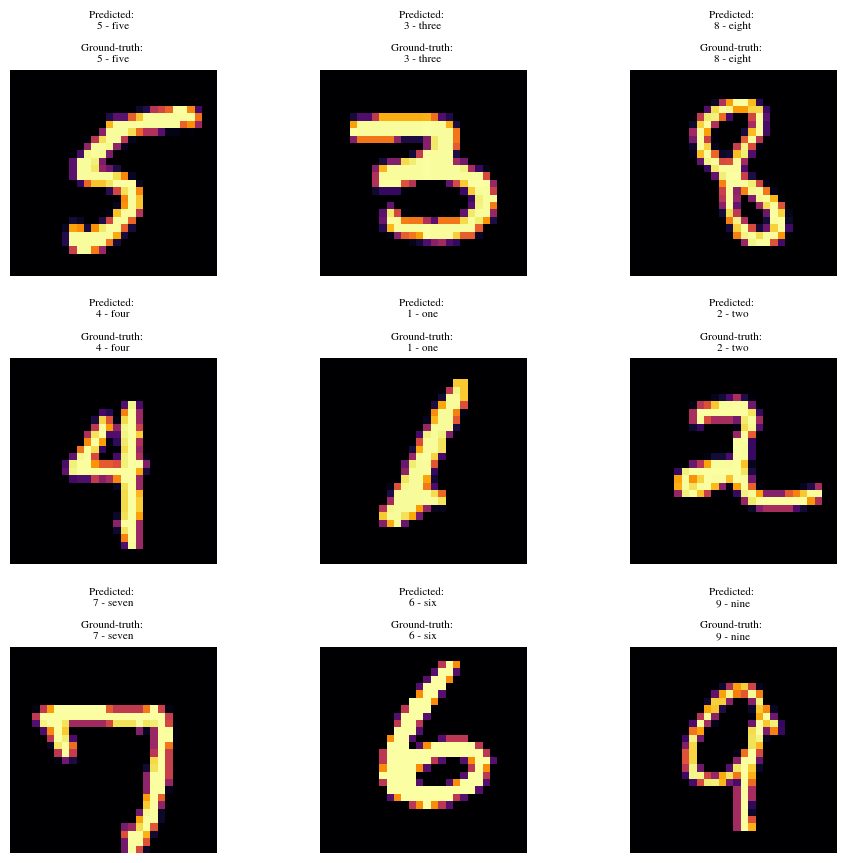

In [ ]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH, labeling_model=MODEL().arch)
model.eval()

test_dataset = DATASET()
test_dataset.prepare_data()
test_dataset.setup("test")
test_dataset = test_dataset.test_set

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()


for index in range(9):

    while True:
        sample_index = random.randint(0, len(test_dataset) - 1)
        target = test_dataset.classes[test_dataset.targets[sample_index]]

        if target not in class_bin:
            class_bin.append(target)
            break
        else:
            continue

    img_raw = Image.fromarray(test_dataset.data[sample_index].numpy())
    img = test_dataset.transform(img_raw).unsqueeze(0).to(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    prediction = model(img)
    prediction = test_dataset.classes[
        torch.argmax(prediction.softmax(1)).data.cpu().numpy()
    ]

    title = f"Predicted: \n{prediction}\n\n"
    title += f"Ground-truth: \n{target}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(img_raw).astype(np.uint8), cmap='inferno')
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()